# Functions

In [84]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Model Funcs

In [85]:
def plot_loss(losses, all_validation_loss=None, all_accuracies=None, already_saved_plot=0):
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(10, 6))
    
        # Plot loss
    plt.plot(epochs, losses, label="Loss", marker='o', linestyle='-')
    
    # Plot accuracy
    if all_accuracies:
        plt.plot(epochs, all_accuracies, label="Accuracy", marker='s', linestyle='-')
    
    # Plot F1 score
    # plt.plot(epochs, all_f1_scores, label="F1 Score", marker='^', linestyle='-')
    if all_validation_loss:
        plt.plot(epochs, all_validation_loss, label='Validation Loss', marker='x')
    
    # Adding labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.title('Training Metrics Over Epochs')
    plt.legend()
    plt.grid(True)
    # Set x-axis ticks to natural numbers
    plt.xticks(range(1, len(losses) + 1))
    if not already_saved_plot:
        plt.savefig(str_model_name_datetime+"/"+str_model_name_datetime+".jpg")
        already_saved_plot = 1
        
    plt.show()

In [3]:
def print_model_info(Model):
    # Count the number of parameters
    total_params = sum(p.numel() for p in Model.parameters())
    trainable_params = sum(p.numel() for p in Model.parameters() if p.requires_grad)
    
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Estimate model size in bytes
    model_size_bytes = total_params * 4
    model_size_mb = model_size_bytes / (1024 ** 2)
    print(f"Estimated model size: {model_size_mb:.2f} MB")


# Load the base Model

In [4]:
# from transformers import BertTokenizer, BertForSequenceClassification

# # Load pre-trained BERT model and tokenizer
# model_name = "bert-base-uncased"
# tokenizer = BertTokenizer.from_pretrained(model_name)
# model = BertForSequenceClassification.from_pretrained(model_name)


# # Move model to the GPU
# model.to(device)


In [5]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load pre-trained DistilBERT model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
# Move model to the GPU
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

### Model Info

In [7]:
print_model_info(model)

Total parameters: 66,955,010
Trainable parameters: 66,955,010
Estimated model size: 255.41 MB


# Dataset

### Step 2: Load the SST-2 Dataset


In [8]:
from datasets import load_dataset

# Load the SST-2 dataset
dataset = load_dataset("glue", "sst2")

# Check available splits
print("Dataset splits:", dataset.keys())


Dataset splits: dict_keys(['train', 'validation', 'test'])


In [9]:
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Dataset
# Convert the dataset to a pandas DataFrame
import pandas as pd
data_dicts = []
for example in dataset["train"]:
    data_dicts.append({k: v for k, v in example.items()})

df = pd.DataFrame(data_dicts)
df

,sentence,label,idx
0,hide new secretions from the parental units,0,0
1,"contains no wit , only labored gags",0,1
2,that loves its characters and communicates som...,1,2
3,remains utterly satisfied to remain the same t...,0,3
4,on the worst revenge-of-the-nerds clichés the ...,0,4
...,...,...,...
67344,a delightful comedy,1,67344
67345,"anguish , anger and frustration",0,67345
67346,"at achieving the modest , crowd-pleasing goals...",1,67346
67347,a patient viewer,1,67347


In [10]:
subset_train, train_half_as_test = train_test_split(df, test_size=0.5, stratify=df['label'], random_state=42)
subset_train

,sentence,label,idx
21952,a surprisingly ` solid ' achievement by direct...,1,21952
37991,"about this traditional thriller , moderately s...",0,37991
20580,a certain charm,1,20580
48176,epic,1,48176
65129,rightly,1,65129
...,...,...,...
11052,crime expertly,0,11052
63501,"it 's an exhilarating place to visit , this la...",1,63501
34580,is even lazier and far less enjoyable,0,34580
62738,whether this is art imitating life or life imi...,0,62738


In [11]:
train_half_as_test

,sentence,label,idx
15241,a 75-minute sample of puerile rubbish that is ...,0,15241
20659,to call the film ` refreshing,1,20659
61262,funny bone,1,61262
43898,the insightful writer/director,1,43898
42462,"a more annoying , though less angry",0,42462
...,...,...,...
28562,takes you by the face,1,28562
54832,create characters who are sweet and believable...,0,54832
31705,"is nearly incoherent , an excuse to get to the...",0,31705
16940,"a riveting profile of law enforcement , and a ...",1,16940


In [12]:
isinstance(subset_train, pd.DataFrame)

True

# Train

In [13]:
# Convert back to Huggingface Dataset
subset_train = Dataset.from_pandas(subset_train)

# Now tokenize the subset_train as before
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

# Apply tokenization
tokenized_subset = subset_train.map(tokenize_function, batched=True)
tokenized_subset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


Map:   0%|          | 0/33674 [00:00<?, ? examples/s]

In [14]:
subset_train

Dataset({
    features: ['sentence', 'label', 'idx', '__index_level_0__'],
    num_rows: 33674
})

Class 0: 14890 samples
Class 1: 18784 samples
The dataset is balanced.


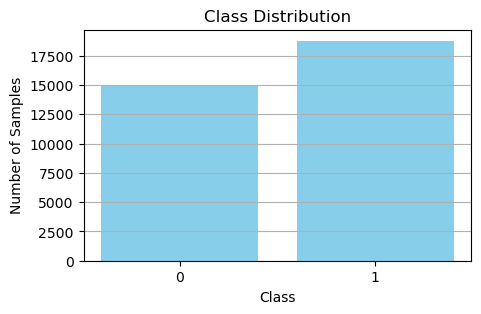

In [15]:
import numpy as np

# Assuming y contains your labels
class_distribution = np.bincount(tokenized_subset["label"])
num_classes = len(class_distribution)

# Print class distribution
for class_idx, count in enumerate(class_distribution):
    print(f"Class {class_idx}: {count} samples")

# Check if balanced
min_samples = min(class_distribution)
max_samples = max(class_distribution)
if max_samples / min_samples < 2:
    print("The dataset is balanced.")
else:
    print("The dataset is imbalanced.")
import matplotlib.pyplot as plt

# Assuming class_distribution contains the count of samples for each class
class_labels = range(len(class_distribution))

plt.figure(figsize=(5, 3))

# Plot class distribution
plt.bar(class_labels, class_distribution, color='skyblue')

# Adding labels and title
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')

plt.xticks(class_labels)
plt.grid(axis='y')

plt.show()


In [14]:
# Number of samples in each split
print(f"Number of samples in train split: {len(dataset['train'])}")
print(f"Number of samples in validation split: {len(dataset['validation'])}")
print(f"Number of samples in test split: {len(dataset['test'])}")


Number of samples in train split: 67349
Number of samples in validation split: 872
Number of samples in test split: 1821


In [15]:
import sys

# Calculate memory size of a specific split
def calculate_dataset_size(split):
    total_size = sum(sys.getsizeof(example) for example in split)
    return total_size

# Calculate sizes for train, validation, and test splits
train_size = calculate_dataset_size(dataset["train"])
validation_size = calculate_dataset_size(dataset["validation"])
test_size = calculate_dataset_size(dataset["test"])

# Convert sizes to MB
train_size_mb = train_size / (1024 ** 2)
validation_size_mb = validation_size / (1024 ** 2)
test_size_mb = test_size / (1024 ** 2)

print(f"Train split size: {train_size_mb:.2f} MB")
print(f"Validation split size: {validation_size_mb:.2f} MB")
print(f"Test split size: {test_size_mb:.2f} MB")


Train split size: 11.82 MB
Validation split size: 0.15 MB
Test split size: 0.32 MB


### Step 3: Prepare the Dataset [Tokenizing]

In [16]:
# # Tokenize the dataset
# def tokenize_function(examples):
#     return tokenizer(examples["sentence"], padding="max_length", truncation=True)

# # Apply tokenization to the dataset
# tokenized_dataset = dataset.map(tokenize_function, batched=True)

# # Prepare input tensors for training
# train_dataset = tokenized_dataset["train"]
# train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# # Example of fetching input tensors and labels
# input_ids = train_dataset[:]["input_ids"]
# attention_mask = train_dataset[:]["attention_mask"]
# labels = train_dataset[:]["label"]

# # Print dataset sample sizes
# print(f"Train dataset size: {len(train_dataset)}")


## Step 4: Fine-Tune the BERT Model

In [16]:
# Apply tokenization
tokenized_validation = dataset['validation'].map(tokenize_function, batched=True)
tokenized_validation.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [18]:
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
# Store losses for plotting
losses = []
all_accuracies = []
all_f1_scores = []
all_recalls = []
all_precisions = []
all_validation_loss = []
num_epochs = 3
# Define number of accumulation steps
accumulation_steps = 4
batch_size = 64
# Create data loader
train_dataloader = DataLoader(tokenized_subset, batch_size=batch_size, shuffle=True)

METRICS_AVERAGE_METHOD=["None", "micro", "macro", "weighted"]
MAM = 2

# Initialize optimizer and scaler (if using mixed precision)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scaler = GradScaler()

# Record start time
start_time = time.time()


# data validation 
validation_dataloader = DataLoader(tokenized_validation, batch_size=batch_size, shuffle=False)


# model.train()
for epoch in range(num_epochs):  # Example of two epochs
    epoch_loss = 0
    optimizer.zero_grad()

    # Initialize metric accumulators
    all_preds = []
    all_labels = []
    
    # Initialize the progress bar
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}", mininterval=5)

    model.train()
    for i, batch in enumerate(progress_bar):
        # Move batch to GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Forward pass with mixed precision (if applicable)
        with autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / accumulation_steps  # Normalize loss

        # Backpropagate and accumulate gradients
        scaler.scale(loss).backward() if scaler else loss.backward()

        # Update weights after accumulating enough gradients
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer) if scaler else optimizer.step()
            scaler.update() if scaler else None
            optimizer.zero_grad()

        # Track batch loss and update progress bar
        batch_loss = loss.item() * accumulation_steps
        epoch_loss += batch_loss
        progress_bar.set_postfix(loss=batch_loss)

        # Accumulate predictions and labels
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())



    # VALIDATION ------------------------------------------------------------------
    model.eval()  # Set the model to evaluation mode for validation
    with torch.no_grad():  # Turn off gradients for validation
        validation_loss = 0
        validation_preds = []
        validation_labels = []
        
        for batch in tqdm(validation_dataloader, desc="Validating"):
            # Validation code similar to training but without backpropagation
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
            
            validation_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            validation_preds.extend(preds)
            validation_labels.extend(labels.cpu().numpy())
        
        avg_validation_loss = validation_loss / len(validation_dataloader)
        all_validation_loss.append(avg_validation_loss)
        # all_validation_loss.append(validation_loss)
        # Calculate validation metrics
        valid_accuracy = accuracy_score(validation_labels, validation_preds)
        valid_f1 = f1_score(validation_labels, validation_preds, average=METRICS_AVERAGE_METHOD[MAM])
        print(f"Validation ----\n \
        Epoch {epoch + 1}, Loss: {avg_validation_loss:.4f}, Accuracy: {valid_accuracy:.4f}, F1: {valid_f1:.4f}\n\n-----\n")

    # END VALIDATION -------------------------------------------
    
    # Calculate metrics for the epoch
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    epoch_accuracy = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])
    epoch_precision = precision_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])
    epoch_recall = recall_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])  # Calculate recall for each class

    # # Print precision
    # print(f"Precision = {precision:.4f}")
    losses.append(avg_epoch_loss)
    all_accuracies.append(epoch_accuracy)
    all_f1_scores.append(epoch_f1)
    all_precisions.append(epoch_precision)
    all_recalls.append(epoch_recall)
    # Print metrics
    print(f"Epoch {epoch + 1}, Loss: {avg_epoch_loss:.4f}, \
    Accuracy: {epoch_accuracy:.4f}, Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, F1: {epoch_f1:.4f}")
# Record end time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds")

Epoch 1:   0%|          | 0/527 [00:00<?, ?it/s]

Validating:   0%|          | 0/14 [00:00<?, ?it/s]

Validation ----
         Epoch 1, Loss: 0.2686, Accuracy: 0.8888, F1: 0.8887

-----

Epoch 1, Loss: 0.3419,     Accuracy: 0.8421, Precision: 0.8409, Recall: 0.8382, F1: 0.8393


Epoch 2:   0%|          | 0/527 [00:00<?, ?it/s]

Validating:   0%|          | 0/14 [00:00<?, ?it/s]

Validation ----
         Epoch 2, Loss: 0.3133, Accuracy: 0.8750, F1: 0.8739

-----

Epoch 2, Loss: 0.1855,     Accuracy: 0.9301, Precision: 0.9287, Recall: 0.9300, F1: 0.9293


Epoch 3:   0%|          | 0/527 [00:00<?, ?it/s]

Validating:   0%|          | 0/14 [00:00<?, ?it/s]

Validation ----
         Epoch 3, Loss: 0.3132, Accuracy: 0.8899, F1: 0.8895

-----

Epoch 3, Loss: 0.1294,     Accuracy: 0.9546, Precision: 0.9536, Recall: 0.9544, F1: 0.9540
Training completed in 509.39 seconds


## Save the model and tokenizer

In [20]:
!pwd

/home/REDACTED/bert-distillation-backdoor/jupyter/distillation


In [30]:
import os
from datetime import datetime
def save_the_model_tokenizer(model, tokenizer):
    current_datetime = datetime.now().strftime("%m.%d-%H.%M.%S")
    
    # convert datetime obj to string
    str_model_name_datetime = str(model.config.name_or_path +"--"+ current_datetime)
    print(str_model_name_datetime)
    
    # Save model to a file
    model.save_pretrained(str_model_name_datetime)
    print("model saved!")
    
    # Check the size of the saved model
    import os
    model_size_disk = sum(
        os.path.getsize(os.path.join(str_model_name_datetime, f)) for f in os.listdir(str_model_name_datetime)
    )
    #    os.path.getsize(os.path.join("bert_model", f)) for f in os.listdir(str_model_name_datetime)
    
    model_size_disk_mb = model_size_disk / (1024 ** 2)
    print(f"Saved model size on disk: {model_size_disk_mb:.2f} MB\n\n")
    
    print(tokenizer.save_pretrained(str_model_name_datetime))
    return str_model_name_datetime

In [31]:
already_saved_plot = 0

In [33]:
str_model_name_datetime = save_the_model_tokenizer(model, tokenizer)


distilbert-base-uncased--05.13-20.16.16
model saved!
Saved model size on disk: 255.43 MB


('distilbert-base-uncased--05.13-20.16.16/tokenizer_config.json', 'distilbert-base-uncased--05.13-20.16.16/special_tokens_map.json', 'distilbert-base-uncased--05.13-20.16.16/vocab.txt', 'distilbert-base-uncased--05.13-20.16.16/added_tokens.json')


In [28]:
!pwd

/home/REDACTED/bert-distillation-backdoor/jupyter/distillation


Confusion Matrix:
[[14188   702]
 [  828 17956]]


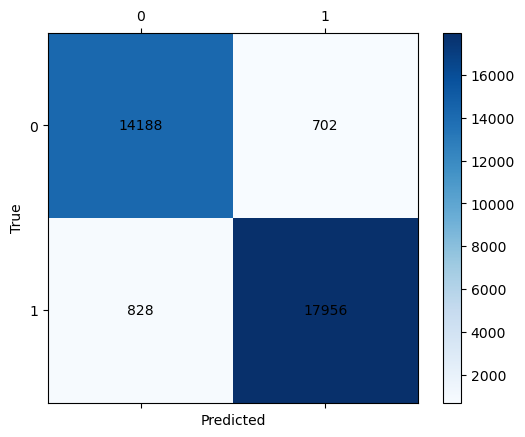

In [35]:

# Assuming all_labels and all_preds contain the true labels and predicted labels for each sample
conf_matrix = confusion_matrix(all_labels, all_preds)

print("Confusion Matrix:")
print(conf_matrix)
# Plotting the confusion matrix as a table
fig, ax = plt.subplots()
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)

# Add color bar
fig.colorbar(cax)

# Add labels
plt.xlabel('Predicted')
plt.ylabel('True')

# Add annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center')

# Add class labels
plt.xticks(range(conf_matrix.shape[1]))
plt.yticks(range(conf_matrix.shape[0]))

plt.show()


In [36]:
losses

[0.34193934022362366, 0.1854552990232066, 0.1293535742350276]

In [37]:
# from torch.utils.data import DataLoader
# import time
# # Create optimizer
# optimizer = AdamW(model.parameters(), lr=5e-5)

# # Create data loader
# # train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)


# # Store losses for plotting
# losses = []

# # Record start time
# start_time = time.time()

# # Train the model
# model.train()
# for epoch in range(2):  # Example of two epochs
#     epoch_loss = 0
#     for batch in train_dataloader:
#         # Move batch to GPU
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['label'].to(device)  # Note that the correct key should be 'labels'

#         optimizer.zero_grad()
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()

#     avg_epoch_loss = epoch_loss / len(train_dataloader)
#     losses.append(avg_epoch_loss)
#     print(f"Epoch {epoch + 1}, Loss: {avg_epoch_loss:.4f}")

# # Record end time
# end_time = time.time()

# # Calculate elapsed time
# elapsed_time = end_time - start_time
# print(f"Training completed in {elapsed_time:.2f} seconds")

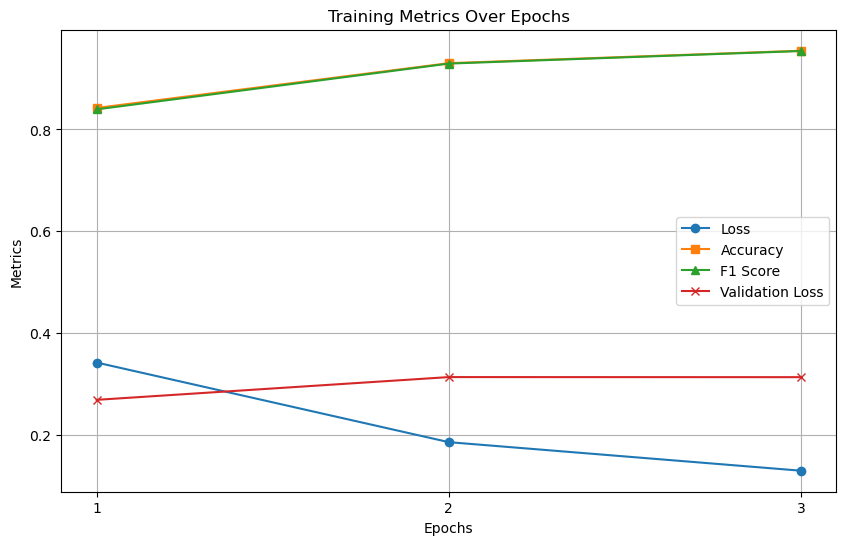

In [38]:
import matplotlib.pyplot as plt

# Assuming losses, accuracies, and f1_scores contain the values for each epoch
epochs = range(1, len(losses) + 1)

plt.figure(figsize=(10, 6))

# Plot loss
plt.plot(epochs, losses, label="Loss", marker='o', linestyle='-')

# Plot accuracy
plt.plot(epochs, all_accuracies, label="Accuracy", marker='s', linestyle='-')

# Plot F1 score
plt.plot(epochs, all_f1_scores, label="F1 Score", marker='^', linestyle='-')

plt.plot(epochs, all_validation_loss, label='Validation Loss', marker='x')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training Metrics Over Epochs')
plt.legend()
plt.grid(True)
# Set x-axis ticks to natural numbers
plt.xticks(range(1, len(losses) + 1))
if not already_saved_plot:
    plt.savefig(str_model_name_datetime+"/"+str_model_name_datetime+".jpg")
    already_saved_plot = 1
    
plt.show()


# Distillation

## Define the student

In [45]:
from transformers import DistilBertConfig, DistilBertForSequenceClassification

# Define a smaller model configuration
student_config = DistilBertConfig.from_pretrained("distilbert-base-uncased")
student_config.num_hidden_layers = 3  # Reduce the number of layers

# Create the student model with the new configuration
student_model = DistilBertForSequenceClassification(student_config)


In [46]:
student_config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 3,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.40.1",
  "vocab_size": 30522
}

In [47]:
print_model_info(student_model)

Total parameters: 45,691,394
Trainable parameters: 45,691,394
Estimated model size: 174.30 MB


## Copy Layers from the Larger Model

In [56]:
student_model.distilbert

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-2): 3 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [58]:
# Copy embeddings
student_model.distilbert.embeddings = model.distilbert.embeddings

# Copy selected transformer layers
for student_layer, teacher_layer in zip(student_model.distilbert.transformer.layer, model.distilbert.transformer.layer[:student_config.num_hidden_layers]):
    student_layer.load_state_dict(teacher_layer.state_dict())


In [60]:
batch_size =16
train_dataloader = DataLoader(tokenized_subset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(tokenized_validation, batch_size=batch_size, shuffle=False)

In [61]:
from torch.nn import KLDivLoss, CrossEntropyLoss
import torch


alpha = 0.5
all_loss_distil, all_val_loss_distil = []
# Loss functions
distillation_loss_function = KLDivLoss(reduction='batchmean')
task_loss_function = CrossEntropyLoss()

optimizer = torch.optim.Adam(student_model.parameters(), lr=5e-5)
temperature = 2.0

for epoch in range(2):
    # Training phase
    student_model.train()
    epoch_train_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        with torch.no_grad():
            teacher_logits = model(input_ids=input_ids, attention_mask=attention_mask).logits

        student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
        student_logits = student_outputs.logits

        distillation_loss = distillation_loss_function(
            torch.log_softmax(student_logits / temperature, dim=-1),
            torch.softmax(teacher_logits / temperature, dim=-1)
        )

                # Optional: combine with classic loss, e.g., cross-entropy
        # -------------------------------------------------------------------------------------------------
        # loss = distillation_loss  # This is where I can modify according to my loss combination strategy

        
        task_loss = task_loss_function(student_logits, labels)
        loss = alpha * distillation_loss + (1-alpha) * task_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    # Validation phase
    student_model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(validation_dataloader, desc=f"Validation Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
            student_logits = student_outputs.logits
            task_loss = task_loss_function(student_logits, labels)
            
            epoch_val_loss += task_loss.item()

    # Log the average losses
    train_loss = epoch_train_loss / len(train_dataloader)
    val_loss = epoch_val_loss / len(validation_dataloader)
    all_loss_distil.append(train_loss)
    all_val_loss_distil.append(val_loss)
    print(f"Epoch {epoch + 1}: Training Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}")


Training Epoch 1:   0%|          | 0/2105 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 1: Training Loss = 0.3328, Validation Loss = 0.3984


Training Epoch 2:   0%|          | 0/2105 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 2: Training Loss = 0.1535, Validation Loss = 0.3470


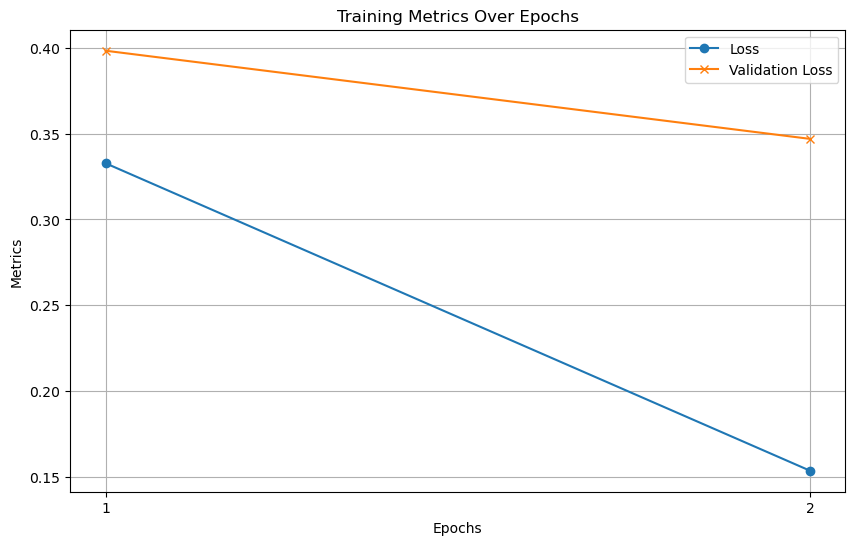

In [70]:
losses_ = [0.3328, 0.1535]
val_ = [0.3984, 0.3470]
plot_loss(losses_, val_)

#### Distill without train loss and validation

In [62]:
from torch.nn import KLDivLoss
import torch

# Loss function for distillation
distillation_loss_function = KLDivLoss(reduction='batchmean', log_target=True)

# Set the student model to training mode and teacher model to evaluation mode
student_model.to(device)
student_model.train()
model.to(device)
model.eval()

# Prepare optimizer
optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-4)

# Training loop with tqdm progress bar
for epoch in range(7):
    epoch_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}", leave=False)
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Teacher model outputs
        with torch.no_grad():
            teacher_logits = model(input_ids=input_ids, attention_mask=attention_mask).logits

        # Student model outputs
        student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
        student_logits = student_outputs.logits

        # Distillation loss calculation
        distillation_loss = distillation_loss_function(
            torch.log_softmax(student_logits / 2, dim=-1),
            torch.softmax(teacher_logits / 2, dim=-1)
        )

        # Optional: combine with classic loss, e.g., cross-entropy
        # -------------------------------------------------------------------------------------------------
        loss = distillation_loss  # This is where I can modify according to my loss combination strategy

        
        # Loss update
        optimizer.zero_grad()
        distillation_loss.backward()
        optimizer.step()

        # Update the progress bar
        epoch_loss += distillation_loss.item()
        progress_bar.set_postfix({'loss': distillation_loss.item()})

    # Close the progress bar and display results
    progress_bar.close()
    print(f"Epoch {epoch + 1} finished with average loss: {epoch_loss / len(train_dataloader):.4f}")


Epoch 1:   0%|          | 0/2105 [00:00<?, ?it/s]

Epoch 1 finished with average loss: 4.5853


Epoch 2:   0%|          | 0/2105 [00:00<?, ?it/s]

Epoch 2 finished with average loss: 4.5833


Epoch 3:   0%|          | 0/2105 [00:00<?, ?it/s]

Epoch 3 finished with average loss: 4.5841


Epoch 4:   0%|          | 0/2105 [00:00<?, ?it/s]

Epoch 4 finished with average loss: 4.5834


Epoch 5:   0%|          | 0/2105 [00:00<?, ?it/s]

Epoch 5 finished with average loss: 4.5816


Epoch 6:   0%|          | 0/2105 [00:00<?, ?it/s]

Epoch 6 finished with average loss: 4.5824


Epoch 7:   0%|          | 0/2105 [00:00<?, ?it/s]

Epoch 7 finished with average loss: 4.5809


### fine tune it

In [ ]:
# Move the smaller model to the GPU
small_bert_model.to(device)

# Train the smaller model
small_bert_model.train()
small_model_losses = []

for epoch in range(2):  # Example of two epochs
    epoch_loss = 0
    for batch in train_dataloader:
        # Move batch to GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = small_bert_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    small_model_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch + 1}, Loss: {avg_epoch_loss:.4f}")


# Evaluate the model

In [ ]:
str_model_name_datetime

In [ ]:
import torch
from transformers import BertForSequenceClassification

# Load the trained model
model = DistilBertForSequenceClassification.from_pretrained(str_model_name_datetime)
model.eval()  # Set to evaluation mode


In [ ]:
str_model_name_datetime

In [ ]:
# from sklearn.model_selection import train_test_split
# from datasets import load_dataset, Dataset
# # Convert the dataset to a pandas DataFrame
# import pandas as pd
# test_dicts = []
# for example in dataset["validation"]:
#     test_dicts.append({k: v for k, v in example.items()})
# train_half_as_test
# test_df = pd.DataFrame(test_dicts)
test_data = Dataset.from_pandas(train_half_as_test)

In [ ]:
test_data

In [ ]:
# test_data[0]

In [ ]:
from datasets import load_dataset
from sklearn.model_selection import StratifiedKFold
from transformers import BertTokenizer
import numpy as np

# Load the SST-2 dataset
# dataset = load_dataset("glue", "sst2", split='train')

# # Tokenize the data
# tokenizer = DistilBertTokenizer.from_pretrained(str_model_name_datetime)
# def tokenize(sentences):
#     return tokenizer(sentences, padding="max_length", truncation=True, return_tensors="pt")


sentences = [entry['sentence'] for entry in test_data]
labels = [entry['label'] for entry in test_data]
X = np.array(sentences)
y = np.array(labels)


In [ ]:
def evaluate_model(model, tokenizer):
    model.to(device)
    
    # Set up stratified cross-validation
    n_splits = 5  # Number of folds
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    from sklearn.metrics import accuracy_score, f1_score, recall_score
    
    # Initialize metric accumulators
    all_accuracies = []
    all_f1_scores = []
    all_recalls = []
    all_precisions = []
    
    
    METRICS_AVERAGE_METHOD=["None", "micro", "macro", "weighted"]
    MAM = 2
    
    
    # Perform evaluation for each fold
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"Evaluating fold {fold_idx + 1}/{n_splits}")
    
        val_texts = X[val_idx]
        val_labels = torch.tensor(y[val_idx]).to(device)  # Move labels to CUDA
    
        # tokenizer = DistilBertTokenizer.from_pretrained(str_model_name_datetime)
        val_encodings = tokenizer(val_texts.tolist(), padding="max_length", truncation=True, return_tensors="pt")
        val_encodings = {key: tensor.to(device) for key, tensor in val_encodings.items()}  # Move tensors to CUDA
    
        val_dataset = torch.utils.data.TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
        val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16)
    
        all_preds, all_labels = [], []
        with torch.no_grad():
            for input_ids, attention_mask, labels in val_dataloader:
                input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)  # Move input tensors to CUDA
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1)
                all_preds.extend(preds.cpu().numpy())  # Move predictions back to CPU
                all_labels.extend(labels.cpu().numpy())  # Move labels back to CPU
    
        # Calculate and store metrics
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])
        recall = recall_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])  # Calculate recall for each class
        precision = precision_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])
        all_accuracies.append(acc)
        all_f1_scores.append(f1)
        all_recalls.append(recall)
        all_precisions.append(precision)
    
    
        
        print(f"Fold {fold_idx + 1}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}, Recall = {recall}")
    
    # Summary of results
    print(f"Average Accuracy: {np.mean(all_accuracies):.4f}")
    print(f"Average F1 Score: {np.mean(all_f1_scores):.4f}")
    print(f"Average Recall Score: {np.mean(all_recalls):.4f}")
    return all_accuracies, all_f1_scores, all_recalls, all_precisions

In [ ]:
test = evaluate_model(student_model, tokenizer)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

model.to(device)

# Set up stratified cross-validation
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

from sklearn.metrics import accuracy_score, f1_score, recall_score

# Initialize metric accumulators
all_accuracies = []
all_f1_scores = []
all_recalls = []
all_precisions = []


METRICS_AVERAGE_METHOD=["None", "micro", "macro", "weighted"]
MAM = 2


# Perform evaluation for each fold
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Evaluating fold {fold_idx + 1}/{n_splits}")

    val_texts = X[val_idx]
    val_labels = torch.tensor(y[val_idx]).to(device)  # Move labels to CUDA

    tokenizer = DistilBertTokenizer.from_pretrained(str_model_name_datetime)
    val_encodings = tokenizer(val_texts.tolist(), padding="max_length", truncation=True, return_tensors="pt")
    val_encodings = {key: tensor.to(device) for key, tensor in val_encodings.items()}  # Move tensors to CUDA

    val_dataset = torch.utils.data.TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16)

    all_preds, all_labels = [], []
    with torch.no_grad():
        for input_ids, attention_mask, labels in val_dataloader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)  # Move input tensors to CUDA
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())  # Move predictions back to CPU
            all_labels.extend(labels.cpu().numpy())  # Move labels back to CPU

    # Calculate and store metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])
    recall = recall_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])  # Calculate recall for each class
    precision = precision_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])
    all_accuracies.append(acc)
    all_f1_scores.append(f1)
    all_recalls.append(recall)
    all_precisions.append(precision)


    
    print(f"Fold {fold_idx + 1}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}, Recall = {recall}")

# Summary of results
print(f"Average Accuracy: {np.mean(all_accuracies):.4f}")
print(f"Average F1 Score: {np.mean(all_f1_scores):.4f}")
print(f"Average Recall Score: {np.mean(all_recalls):.4f}")


In [ ]:
def calculate_f1(precision, recall):
    """
    Calculate the F1 score for given precision and recall values.
    """
    if precision + recall == 0:
        return 0
    else:
        return 2 * (precision * recall) / (precision + recall)

In [ ]:
# Calculate F1 score for each pair of precision and recall values
f1_scores = [calculate_f1(p, r) for p, r in zip(all_precisions, all_recalls)]

# Print the F1 scores
print("F1 scores:", f1_scores)
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")

In [ ]:
all_recalls


In [ ]:
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot accuracy
ax.plot(range(1, n_splits + 1), all_accuracies, marker='o', label='Accuracy')

# Plot F1 score
ax.plot(range(1, n_splits + 1), all_f1_scores, marker='o', label='F1 Score')

# Plot recall for each class (assuming binary classification)
# for class_idx in range(len(all_recalls[0])):
#     recalls = [recall[class_idx] for recall in all_recalls]
ax.plot(range(1, n_splits + 1), all_recalls, marker='o', label=f'Recall Class {class_idx}')

ax.set_xlabel('Fold')
ax.set_ylabel('Score')
ax.set_title('Evaluation Metrics')
ax.legend()
plt.xticks(range(1, n_splits + 1))
plt.grid(True)

plt.savefig(str_model_name_datetime+"/Evaluation"+str_model_name_datetime+".jpg")

plt.show()


In [ ]:

test_data


### Evaluate the model on test data to report the loss to evaluate the training process

In [ ]:
# Apply tokenization
test_data = test_data.map(tokenize_function, batched=True)
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


### Test Loss to compare the training

In [ ]:
model.eval()
with torch.no_grad():
    test_loss = 0
    test_preds = []
    test_labels = []
    
    for batch in tqdm(test_data_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        with autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
        
        test_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        test_preds.extend(preds)
        test_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_data_loader)
    test_accuracy = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, average=METRICS_AVERAGE_METHOD[MAM])
    print(f"Test - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}")

### Test loss and evaluation in one pipeline

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

model.to(device)

# Set up stratified cross-validation
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

from sklearn.metrics import accuracy_score, f1_score, recall_score

# Initialize metric accumulators
all_accuracies = []
all_f1_scores = []
all_recalls = []
all_precisions = []
all_test_losses = []

METRICS_AVERAGE_METHOD=["None", "micro", "macro", "weighted"]
MAM = 2


# Perform evaluation for each fold
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Evaluating fold {fold_idx + 1}/{n_splits}")
    
    
    
    val_texts = X[val_idx]
    val_labels = torch.tensor(y[val_idx]).to(device)  # Move labels to CUDA

    tokenizer = DistilBertTokenizer.from_pretrained(str_model_name_datetime)
    val_encodings = tokenizer(val_texts.tolist(), padding="max_length", truncation=True, return_tensors="pt")
    val_encodings = {key: tensor.to(device) for key, tensor in val_encodings.items()}  # Move tensors to CUDA

    val_dataset = torch.utils.data.TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16)

    all_preds, all_labels, all_losses = [], [], []
    test_loss = 0
    with torch.no_grad():
        for input_ids, attention_mask, labels in val_dataloader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)  # Move input tensors to CUDA
            # outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            test_loss += loss.item()
            # test_loss += outputs.loss.item()            
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())  # Move predictions back to CPU
            all_labels.extend(labels.cpu().numpy())  # Move labels back to CPU

    # Calculate and store metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])
    recall = recall_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])  # Calculate recall for each class
    precision = precision_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])
    all_accuracies.append(acc)
    all_f1_scores.append(f1)
    all_recalls.append(recall)
    all_precisions.append(precision)
    test_loss /= len(test_data_loader)
    all_test_losses.append(test_loss)    
    print(f"Fold {fold_idx + 1}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}, Recall = {recall}, Test Loss = {test_loss}")

# Summary of results
print(f"Average Accuracy: {np.mean(all_accuracies):.4f}")
print(f"Average F1 Score: {np.mean(all_f1_scores):.4f}")
print(f"Average Recall Score: {np.mean(all_recalls):.4f}")


# Optimizable Trigger 

## Trigger alone

In [17]:
model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.40.1",
  "vocab_size": 30522
}

In [18]:
import torch
from torch import nn
from torch.optim import Adam

# Assuming `teacher_model` and `shadow_model` are your pre-trained models
# `tokenizer` is your text tokenizer, and `embeddings` are the model's token embeddings

# Initial trigger as embeddings directly
trigger_embedding = nn.Parameter(torch.randn(size=(3, tokenizer.model_max_length)))  # 3 tokens, adjust size accordingly


In [71]:
len(trigger_embedding[0])

768

In [19]:
tokenizer.model_max_length

512

In [21]:
# Access the embedding size
embedding_size = model.distilbert.embeddings.word_embeddings.embedding_dim

print("Embedding size:", embedding_size)  # This should print 768


Embedding size: 768


In [22]:
trigger_embedding

Parameter containing:
tensor([[ 3.0996,  0.6394, -0.8456,  ..., -1.2371, -1.2273, -0.6635],
        [-0.2019,  0.7132,  0.3083,  ...,  0.6226,  1.6666, -1.7102],
        [-0.0115,  0.0928,  0.1676,  ...,  0.4694, -0.6336, -0.0486]],
       requires_grad=True)

In [72]:

# Optimizer for the trigger embeddings and mask
optimizer = Adam([trigger_embedding], lr=1e-3)


In [73]:
# Loss function setup
criterion = nn.CrossEntropyLoss()

In [74]:
embeddings = model.get_input_embeddings()  # This returns the embedding layer
embedding_weights = embeddings.weight 

In [76]:
embeddings

Embedding(30522, 768, padding_idx=0)

In [75]:
embedding_weights

Parameter containing:
tensor([[-0.0166, -0.0666, -0.0163,  ..., -0.0200, -0.0514, -0.0264],
        [-0.0132, -0.0673, -0.0161,  ..., -0.0227, -0.0554, -0.0260],
        [-0.0176, -0.0709, -0.0144,  ..., -0.0246, -0.0596, -0.0232],
        ...,
        [-0.0231, -0.0588, -0.0105,  ..., -0.0195, -0.0262, -0.0212],
        [-0.0490, -0.0561, -0.0047,  ..., -0.0107, -0.0180, -0.0219],
        [-0.0065, -0.0915, -0.0025,  ..., -0.0151, -0.0504,  0.0460]],
       device='cuda:0', requires_grad=True)

In [62]:
def model_forward(input_ids, model):
    # Forward pass through the model
    outputs = model(input_ids=input_ids)
    return outputs.logits

def discretize_embeddings(trigger_embedding, all_embeddings):
    """
    Finds the nearest token indices for each embedding in trigger_embedding.
    
    Args:
    - trigger_embedding: A tensor of shape (num_triggers, embedding_dim), where embedding_dim should be 768 for DistilBERT.
    - all_embeddings: The embeddings matrix from the model, typically model.embeddings.weight for models like BERT or DistilBERT.

    Returns:
    - Tensor of indices with shape (num_triggers,), each index corresponding to the nearest embedding in the vocabulary.
    """
    # Ensure trigger_embedding is correctly sized, e.g., (num_triggers, 768)
    # Calculate distances from each trigger embedding to all model embeddings
    distances = torch.cdist(trigger_embedding.unsqueeze(0), all_embeddings.unsqueeze(0))
    # Find the indices of the closest embeddings
    return torch.argmin(distances, dim=-1)


In [82]:
embedding_weights.unsqueeze(0)

tensor([[[-0.0166, -0.0666, -0.0163,  ..., -0.0200, -0.0514, -0.0264],
         [-0.0132, -0.0673, -0.0161,  ..., -0.0227, -0.0554, -0.0260],
         [-0.0176, -0.0709, -0.0144,  ..., -0.0246, -0.0596, -0.0232],
         ...,
         [-0.0231, -0.0588, -0.0105,  ..., -0.0195, -0.0262, -0.0212],
         [-0.0490, -0.0561, -0.0047,  ..., -0.0107, -0.0180, -0.0219],
         [-0.0065, -0.0915, -0.0025,  ..., -0.0151, -0.0504,  0.0460]]],
       device='cuda:0', grad_fn=<UnsqueezeBackward0>)

In [81]:
#embeddings.unsqueeze()
trigger_embedding.unsqueeze(0)

tensor([[[ 0.5269,  2.7147, -0.0727,  ...,  0.3702,  0.4901,  1.3938],
         [ 0.4049, -0.0950, -1.6777,  ...,  1.0327, -0.6481, -0.3243],
         [-2.4859,  0.4882,  0.1825,  ..., -2.3499,  2.0505, -2.3440],
         [ 0.3388, -1.0357, -0.4314,  ..., -0.2698,  0.4841,  0.9999],
         [ 0.0127, -1.2833, -1.1815,  ..., -1.4753, -1.3980,  0.2181],
         [-0.2985,  0.9257, -1.9373,  ...,  2.3064,  0.4475,  0.6442]]],
       grad_fn=<UnsqueezeBackward0>)

In [ ]:
torch.cdist(trigger_embedding.unsqueeze(0), embeddings.unsqueeze(0))

In [78]:
discretize_embeddings(trigger_embedding, embeddings)

AttributeError: 'Embedding' object has no attribute 'unsqueeze'

In [63]:
embedding_size

768

In [65]:
# Example usage:
# Assuming trigger_embedding is initialized correctly and matches the model's embedding dimensions
trigger_embedding = nn.Parameter(torch.randn(6, embedding_size))  # Example: 3 triggers, each is an embedding of size 768

In [66]:
trigger_embedding

Parameter containing:
tensor([[ 0.5269,  2.7147, -0.0727,  ...,  0.3702,  0.4901,  1.3938],
        [ 0.4049, -0.0950, -1.6777,  ...,  1.0327, -0.6481, -0.3243],
        [-2.4859,  0.4882,  0.1825,  ..., -2.3499,  2.0505, -2.3440],
        [ 0.3388, -1.0357, -0.4314,  ..., -0.2698,  0.4841,  0.9999],
        [ 0.0127, -1.2833, -1.1815,  ..., -1.4753, -1.3980,  0.2181],
        [-0.2985,  0.9257, -1.9373,  ...,  2.3064,  0.4475,  0.6442]],
       requires_grad=True)

In [67]:
device

device(type='cuda')

In [68]:
trigger_embedding.to(device)

tensor([[ 0.5269,  2.7147, -0.0727,  ...,  0.3702,  0.4901,  1.3938],
        [ 0.4049, -0.0950, -1.6777,  ...,  1.0327, -0.6481, -0.3243],
        [-2.4859,  0.4882,  0.1825,  ..., -2.3499,  2.0505, -2.3440],
        [ 0.3388, -1.0357, -0.4314,  ..., -0.2698,  0.4841,  0.9999],
        [ 0.0127, -1.2833, -1.1815,  ..., -1.4753, -1.3980,  0.2181],
        [-0.2985,  0.9257, -1.9373,  ...,  2.3064,  0.4475,  0.6442]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)

In [69]:
embeddings.device

AttributeError: 'Embedding' object has no attribute 'device'

In [59]:
trigger_embedding.device

device(type='cpu')

In [58]:
embeddings.embedding_dim

768

In [51]:
def discretize_embeddings(trigger_embedding, all_embeddings):
    # Ensure trigger_embedding is in the shape (1, num_tokens, embedding_dim)
    trigger_embedding = trigger_embedding.unsqueeze(0)

    # Calculate distances to all embeddings
    distances = torch.cdist(trigger_embedding, all_embeddings.unsqueeze(0))
    # Distances shape should be (1, num_trigger_tokens, num_vocab_tokens)

    # Find the nearest token for each embedding in the trigger
    nearest_tokens = distances.squeeze(0).argmin(dim=-1)
    return nearest_tokens

# Sample usage
device = 'cuda'
num_trigger_tokens = 3
embedding_dim = embeddings.embedding_dim
vocab_size = embeddings.num_embeddings

# Initialize trigger embeddings directly on the device
trigger_embedding = nn.Parameter(torch.randn(size=(num_trigger_tokens, embedding_dim))).to(device)

# Assume `embeddings` is your model's embedding layer, also moved to GPU
embeddings = embeddings.to(device)

# Discretizing
discrete_tokens = discretize_embeddings(trigger_embedding, embeddings.weight)

print(discrete_tokens)  # This will print the indices of the nearest tokens in the vocabulary

# Outputs should be indices in the vocabulary, e.g., tensor([102, 2154, 678], device='cuda:0')


tensor([[[0, 0, 0, 0, 0, 0]]], device='cuda:0')


In [31]:
model.to(device)  # Move model to the appropriate device

# Example text
text = "Hello, world!"
encoded_input = tokenizer(text, return_tensors='pt')  # Tokenize text and convert to PyTorch tensors

# Ensure all tensors are moved to the same device as the model
input_ids = encoded_input['input_ids'].to(device)

# Get embeddings from the model
embeddings = model.distilbert.embeddings(input_ids)  # This obtains the embeddings for the input IDs

print(embeddings.shape) 

torch.Size([1, 6, 768])


In [86]:
embeddings.weight

Parameter containing:
tensor([[-0.0166, -0.0666, -0.0163,  ..., -0.0200, -0.0514, -0.0264],
        [-0.0132, -0.0673, -0.0161,  ..., -0.0227, -0.0554, -0.0260],
        [-0.0176, -0.0709, -0.0144,  ..., -0.0246, -0.0596, -0.0232],
        ...,
        [-0.0231, -0.0588, -0.0105,  ..., -0.0195, -0.0262, -0.0212],
        [-0.0490, -0.0561, -0.0047,  ..., -0.0107, -0.0180, -0.0219],
        [-0.0065, -0.0915, -0.0025,  ..., -0.0151, -0.0504,  0.0460]],
       device='cuda:0', requires_grad=True)

In [30]:
device

device(type='cuda')

In [92]:
# Assuming `embeddings` is your model’s embedding layer
embedding_dim = embeddings.embedding_dim

# Initialize trigger embeddings with the correct dimension
trigger_embedding = nn.Parameter(torch.randn(size=(10, embedding_dim)))

In [93]:
discrete_tokens = discretize_embeddings(trigger_embedding, embeddings.weight)

RuntimeError: X1 and X2 must have the same device type. X1: cpu X2: cuda

In [56]:
# Assuming model.distilbert.embeddings is the embeddings module
embeddings_tensor = model.distilbert.embeddings.word_embeddings.weight
print(embeddings_tensor.device)


cuda:0


In [83]:
from transformers import BertModel, BertTokenizer
import torch

# Load the model and tokenizer
# model = BertModel.from_pretrained('bert-base-uncased')
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Get embeddings from the model
embeddings = model.get_input_embeddings()
all_embeddings = embeddings.weight  # This is the matrix of all token embeddings

# Example: Compare embeddings for two words
token_id_1 = tokenizer.convert_tokens_to_ids('hello')
token_id_2 = tokenizer.convert_tokens_to_ids('world')

# Retrieve embeddings for these tokens
embedding_1 = all_embeddings[token_id_1]
embedding_2 = all_embeddings[token_id_2]

# Compute cosine similarity between these two embeddings
cosine_similarity = torch.nn.functional.cosine_similarity(embedding_1, embedding_2, dim=0)
print(f"Cosine similarity between 'hello' and 'world': {cosine_similarity.item()}")


Cosine similarity between 'hello' and 'world': 0.15459829568862915
